In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
from pandas.tseries.offsets import BDay

import backtest_tools.portfolio_tools as backtest_tools
import backtest_tools.data_cleaning_tools as cleaning
import pickle

In [5]:
import pandas_ta as ta

In [266]:
path = r'C:\Users\marcu\Documents\Quant\Programming\Data\russell_300_returns.pickle'
with open(path, 'rb') as reader:
    tickers = pickle.load(reader).columns

In [267]:
tickers

Index(['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'NVDA', 'XOM', 'TSLA', 'UNH',
       'JNJ',
       ...
       'TUP', 'RLMD', 'DHC', 'INSG', 'VXRT', 'EGIO', 'TTCF', 'YMAB', 'EIGR',
       'GOSS'],
      dtype='object', length=2257)

In [273]:
data = yf.download('AAPL', start='1995-01-01', end='2023-02-11')

[*********************100%***********************]  1 of 1 completed


In [608]:
def strategy(data, ticker):
    data['RSI'] = ta.rsi(data['Adj Close'])
    data['200_EMA'] = ta.ema(data['Adj Close'], length=200)
    data['50_EMA'] = ta.ema(data['Adj Close'], length=50)
    data['Open Pct Change'] = data['Open'].pct_change() 
    data['Close Pct Change'] = data['Adj Close'] / data['Adj Close'].shift(1) -1

    # data['Longs'] = np.where((data['RSI'] < 30) & (data['Adj Close'] > data['200_EMA']), 1, 0)
    # data['Shorts']  = np.where((data['RSI'] > 70) & (data['Adj Close'] < data['200_EMA']), -1, 0)

    data['Longs'] = np.where((data['Adj Close'] >= data['200_EMA']) & (data['Adj Close'] > data['50_EMA']), -1, 0) # & (data['Adj Close'] > data['50_EMA'])
    data['Longs'] = data['Longs'].shift(2)
    data['Shorts']  = np.where((data['Adj Close'] < data['200_EMA']) & (data['Adj Close'] < data['50_EMA']), 1, 0) #  & (data['Adj Close'] < data['50_EMA'])
    data['Shorts'] = data['Shorts'].shift(2)
    
    #data['Positions'] = data['Longs'].join(data['Shorts']) # pd.concat([data['Longs'], data['Shorts']])
    data['Positions'] = data['Longs'] + data['Shorts']
    #data['Positions'] = np.where(data['Adj Close'] >= data['200_EMA'], 1, -1)
    
    strategy_returns = pd.Series(data['Open Pct Change'] * data['Positions'], name=ticker)

    return strategy_returns

    # get dates in which we are long (buy)
    # buy_dates_index = np.where(data['Longs']>0)[0] + 2
    # short_dates_index = np.where(data['Shorts']<0)[0] + 2

    # sell_dates = []
    # for i in buy_dates_index:
        # for j in range(0, 11):
            # if data['RSI'].iloc[i + j] < 40 & j != 10:
        # if data['200_EMA'].iloc[i] < data['Adj Close']:
        #     np.append(buy_dates_index, i + j + 1)

    # data['Buy'] = pd.Series(index=data.index)
    # data['Buy'].iloc[buy_dates_index] = np.ones(buy_dates_index.shape[0])

    # data['Sell'] = pd.Series(index=data.index)
    # data['Sell'].iloc[short_dates_index] = np.ones(short_dates_index.shape[0])*-1

In [609]:
strategy_returns = {}

for ticker in tickers[-100:]:
    data = yf.download(ticker, start='1995-01-01', end='2023-02-11')
    try:
        strategy_returns[ticker] = strategy(data, ticker)
    except:
        pass

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<AxesSubplot:xlabel='Date'>

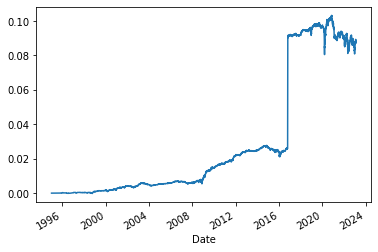

In [610]:
tmp_strategy_returns = pd.DataFrame(strategy_returns).apply(apply_function).sum(1)
backtest_tools.cumulative_returns(tmp_strategy_returns).plot()

In [611]:
backtest_tools.performance_summary(tmp_strategy_returns)

Sharpe Ratio                      0.244994
Drift Adjusted Sharpe Ratio       0.077145
CAGR                              0.002983
Vol                               0.012462
Sortino Ratio                     0.987078
Martin (Ulcer) Ratio              0.000536
Omega Ratio                       0.082714
RR Ratio                          1.250030
Win Rate                          0.514759
Skew                             74.039343
Kurtosis                       5967.211965
Max Drawdown                     -0.020252
VaR - Laplace                    -0.002940
CVaR - Laplace                   -0.003665
dtype: float64

<AxesSubplot:xlabel='Date'>

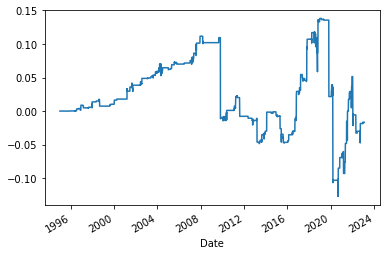

In [359]:
def apply_function(returns):
    return returns / returns.dropna().shape[0]

backtest_tools.cumulative_returns(pd.DataFrame(strategy_returns).apply(apply_function).sum(1)).plot()

In [358]:
backtest_tools.performance_summary(pd.DataFrame(strategy_returns).sum(1))

Sharpe Ratio                     0.278783
Drift Adjusted Sharpe Ratio      0.034588
CAGR                             0.035765
Vol                              0.188454
Sortino Ratio                    0.436839
Martin (Ulcer) Ratio             0.000189
Omega Ratio                      0.948738
RR Ratio                         1.228537
Win Rate                         0.518519
Skew                             3.683555
Kurtosis                       143.621458
Max Drawdown                    -0.629315
VaR - Laplace                   -0.047892
CVaR - Laplace                  -0.061047
dtype: float64

In [309]:
strategy_returns.sum()

9.022604949039682

Sharpe Ratio                    -0.267759
Drift Adjusted Sharpe Ratio     -0.053382
CAGR                            -0.047879
Vol                              0.143590
Sortino Ratio                   -0.344503
Martin (Ulcer) Ratio            -0.000041
Omega Ratio                      0.549653
RR Ratio                         0.772711
Win Rate                         0.432526
Skew                            -3.608200
Kurtosis                       171.109888
Max Drawdown                    -0.785942
VaR - Laplace                   -0.036959
CVaR - Laplace                  -0.046194
dtype: float64

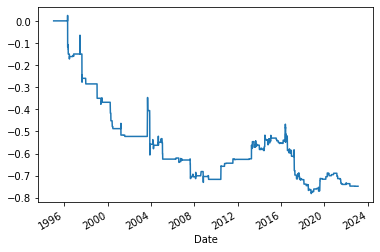

In [313]:
backtest_tools.cumulative_returns(strategy_returns).plot()
backtest_tools.performance_summary(strategy_returns)

<AxesSubplot:xlabel='Date'>

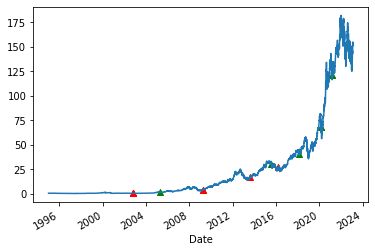

In [278]:
plt.scatter(data['Close'].iloc[np.where(data['Shorts']<0)].index, data['Close'].iloc[np.where(data['Shorts']<0)], marker='^', c='r')
plt.scatter(data['Close'].iloc[np.where(data['Longs']>0)].index, data['Close'].iloc[np.where(data['Longs']>0)], marker='^', c='g')
data.Close.plot()